## Configuration

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

In [3]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-74, 222), continuous_update=False, description='Energy Price Interval', max=900, min=-4…

DatePicker(value=datetime.date(2024, 10, 29), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [4]:
merged_df, e_price_df = get_datasets()

## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [5]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [18]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df)

features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



In [7]:
X_train.tail(1)

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2024-07-09 08:00:00,8,191,1,98.88,103.046667,101.4925,98.726,97.461667,96.835714,96.72625,...,0.0,0.036821,0.019896,0.358696,0.021383,0.061455,18.923477,0.0,20.562017,442.97348


In [8]:
X_val.tail(1)

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2024-10-28 19:00:00,19,302,0,147.460,145.343333,140.0575,136.318,132.586667,128.121429,123.97250,...,0.0,0.039111,0.019787,0.0,0.054974,0.222449,11.910435,0.034783,17.443888,0.0
2024-10-28 20:00:00,20,302,0,135.155,139.703333,140.0550,136.884,134.296667,131.387143,127.63000,...,0.0,0.040273,0.009089,0.0,0.046415,0.228721,11.675652,0.034783,18.594957,0.0
2024-10-28 21:00:00,21,302,0,119.890,128.633333,133.6750,135.162,133.335000,131.624286,129.41250,...,0.0,0.041531,0.005386,0.0,0.039369,0.227769,11.393043,0.008696,21.272535,0.0
2024-10-28 22:00:00,22,302,0,112.775,116.580000,123.9650,128.932,130.961667,129.995714,128.91625,...,0.0,0.042891,0.001725,0.0,0.036500,0.218160,11.158260,0.008696,23.076227,0.0
2024-10-28 23:00:00,23,302,0,106.185,109.320000,113.0375,119.654,124.511667,126.882857,126.54750,...,0.0,0.045137,0.000688,0.0,0.031154,0.207098,10.869131,0.004348,23.552510,0.0


In [9]:
X_test.tail(1)

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2024-10-29 19:00:00,19,303,1,230.630,249.020000,239.9450,226.408,211.330000,197.958571,186.39500,...,0.0,0.040608,0.030011,0.0,0.026560,0.090070,12.706086,0.030435,33.168320,0.0
2024-10-29 20:00:00,20,303,1,172.210,200.620000,221.9150,220.076,212.106667,201.225714,190.78875,...,0.0,0.044794,0.014459,0.0,0.027928,0.097331,12.095218,0.000000,31.254880,0.0
2024-10-29 21:00:00,21,303,1,132.325,156.156667,181.4775,202.342,204.071667,199.527143,191.57875,...,0.0,0.046835,0.002805,0.0,0.030024,0.096333,11.658260,0.008696,28.722576,0.0
2024-10-29 22:00:00,22,303,1,121.065,127.576667,146.6375,168.798,188.298333,191.787143,189.34625,...,0.0,0.046154,0.001140,0.0,0.035149,0.097447,11.536522,0.004348,26.723137,0.0
2024-10-29 23:00:00,23,303,1,110.585,115.073333,121.4550,137.928,157.846667,176.125714,180.70000,...,0.0,0.046156,0.000599,0.0,0.040935,0.102369,11.390869,0.039130,25.068104,0.0


In [10]:
# plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
# plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [11]:
lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [19]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)

[0]	validation_0-rmse:86.89350
[25]	validation_0-rmse:20.50316
[50]	validation_0-rmse:9.03190
[75]	validation_0-rmse:7.62713
[100]	validation_0-rmse:7.38859
[125]	validation_0-rmse:7.34098
[149]	validation_0-rmse:7.30118
[0]	validation_0-mae:75.28754
[25]	validation_0-mae:16.35119
[50]	validation_0-mae:5.28599
[75]	validation_0-mae:3.80450
[100]	validation_0-mae:3.65505
[125]	validation_0-mae:3.63661
[149]	validation_0-mae:3.63252


### Prophet

In [13]:
# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 1.0,
    holidays_prior_scale = 1.0,
    seasonality_mode= 'multiplicative'
)
#Add fourier order for weekly and monthly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=10)
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)

# Add time-based regressors
for feature in FEATURES:
     model.add_regressor(feature)
     
train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

model.fit(train_data)


14:07:41 - cmdstanpy - INFO - Chain [1] start processing
14:09:52 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
test_data = test.reset_index().rename(columns={"index": "ds"}).dropna()
test_data.drop(columns=["Price"])
prophet_predictions = model.predict(test_data)["yhat"]

## Results

### Errors

In [15]:
calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

            Model      MAE       MSE     RMSE     MAPE
Linear Regression 5.144720 60.276365 7.763785 3.149475
          Prophet 4.799343 56.923808 7.544787 2.844570
          XGBoost 4.110762 38.732085 6.223511 2.544842


### Plots

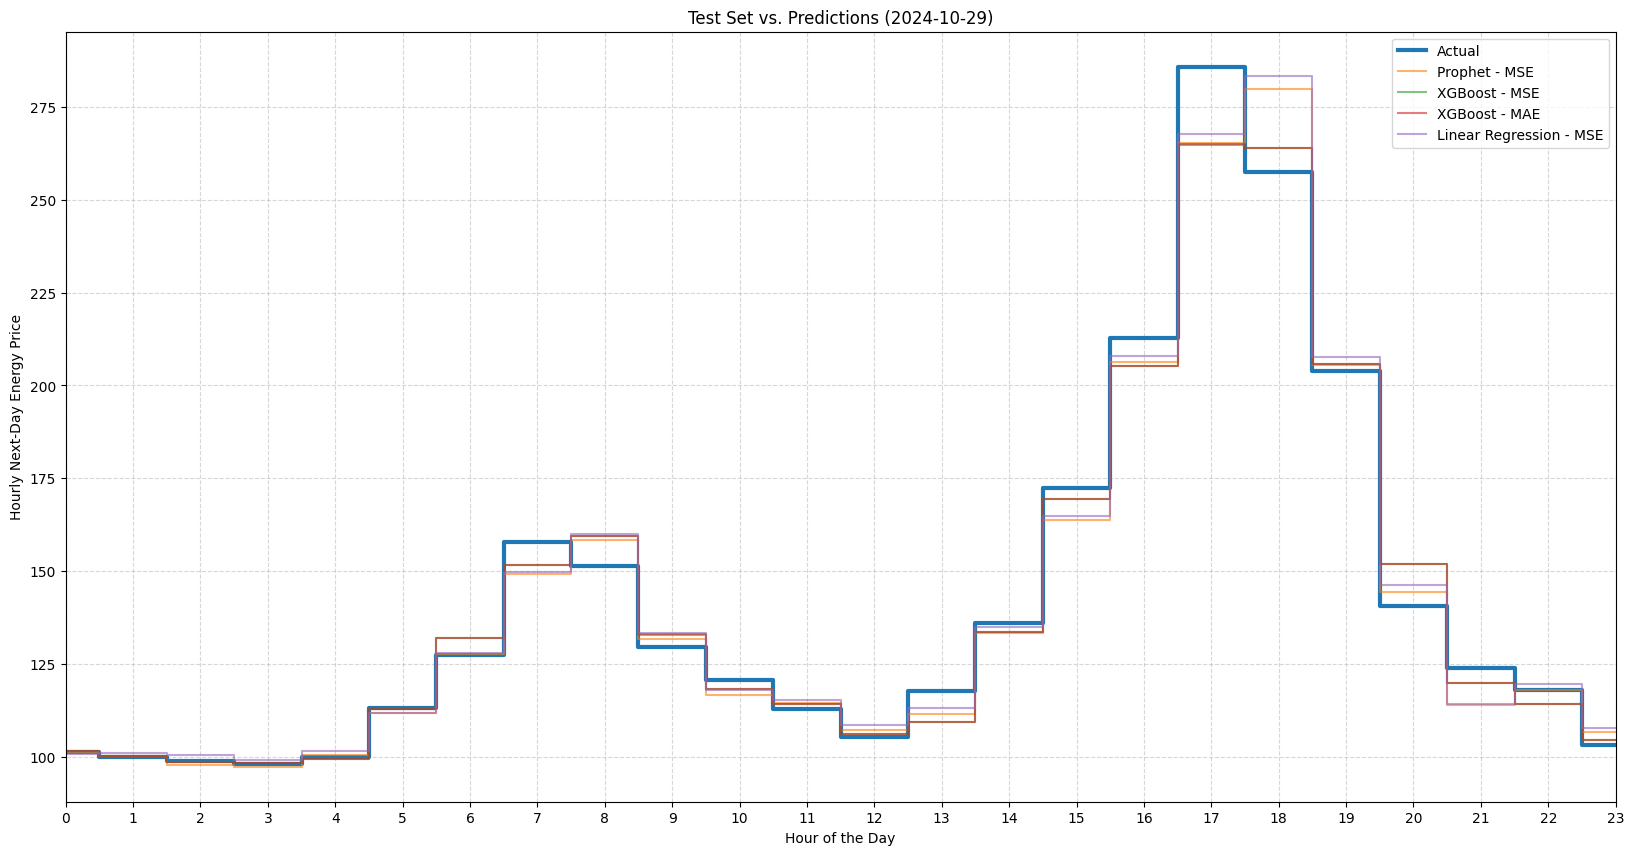

In [16]:
predictions = [(prophet_predictions, "Prophet","MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

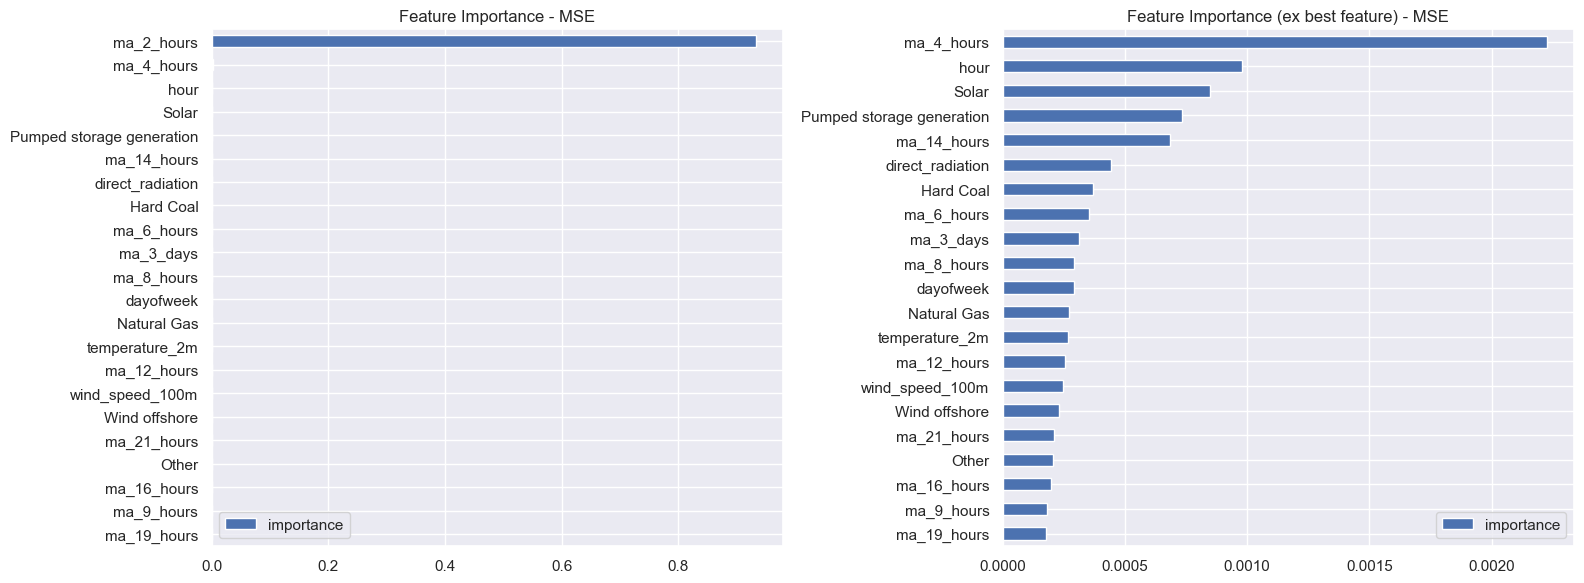

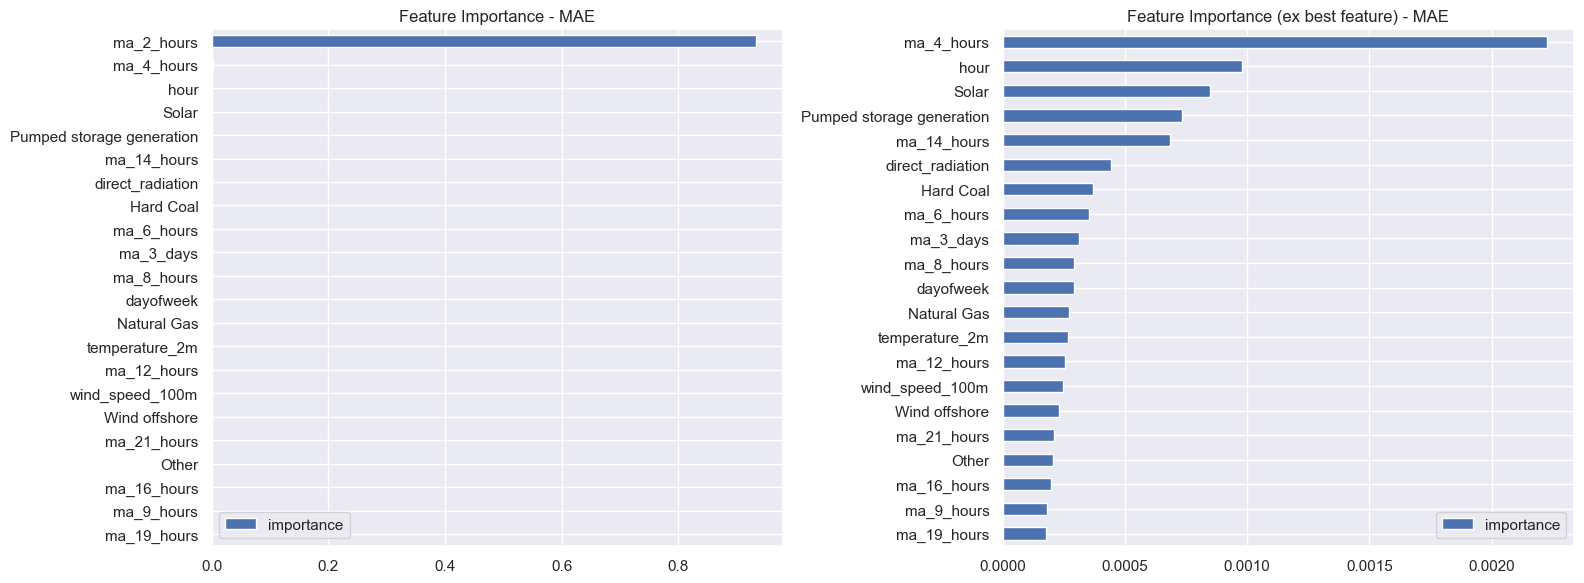

In [17]:
feature_importance(xgb_mse, "MSE")
feature_importance(xgb_mae, "MAE")